In [208]:
import torch
import json
from keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd
from keras.preprocessing.text import Tokenizer
import torch.nn as nn
import numpy as np, pickle, time, argparse
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

import tensorflow as tf
import contractions
from sklearn.preprocessing import LabelBinarizer
import time
import tensorflow.keras as k
import os
import matplotlib.pyplot as plt

In [47]:
"deal with contracted texts"
def expand_text(text):
    expanded_words = []
    text = text.encode('utf-8').decode('cp1252').replace("Â’", "'")
    #text = text.replace("’", "'")
    for word in text.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text



"clean dataset"
def preprocess_text(x):
    for punct in '"!&?.,}-/<>#$%\()*+:;=?@[\\]^_`|\~':
        x = x.replace(punct, ' ')
    x = ' '.join(x.split())
    x = x.lower()
    
    return x


def create_utterances(filename, split):
    sentences, emotion_labels, speakers, conv_id, = [], [], [], []
    
    lengths = []
    with open(filename, 'r', encoding='latin1') as f:
        a = json.load(f)
        for c_id, line in enumerate(a):
            for item in line:
                sentences.append(item['utterance'])
                emotion_labels.append(item['emotion'])
                conv_id.append(split[:2] + '_c' + str(c_id))
                speakers.append(item['speaker'])
            
            # u_id += 1
                
    data = pd.DataFrame(sentences, columns=['sentence'])
    data['sentence'] = data['sentence'].apply(lambda x: expand_text(x))
    data['sentence'] = data['sentence'].apply(lambda x: preprocess_text(x))

    data['emotion_label'] = emotion_labels
    data['speaker'] = speakers
    data['conv_id'] = conv_id

    
    return data


In [48]:
"create embedding"
def load_pretrained_glove():
    print("Loading GloVe model, this can take some time...")
    glv_vector = {}
    f = open('glove.840B.300d.txt', encoding='utf-8')

    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]


if __name__ == '__main__':

    train_data = create_utterances('Friends/friends_train.json', 'train')
    valid_data = create_utterances('Friends/friends_dev.json', 'valid')
    test_data = create_utterances('Friends/friends_test.json', 'test')
    
    ## encode the emotion and dialog act labels ##
    all_emotion_labels =  set(train_data['emotion_label'])
    emotion_label_encoder, emotion_label_decoder = {}, {}


    for i, label in enumerate(all_emotion_labels):
        emotion_label_encoder[label] = i
        emotion_label_decoder[i] = label


    pickle.dump(emotion_label_encoder, open('emotion_label_encoder.pkl', 'wb'))
    pickle.dump(emotion_label_decoder, open('emotion_label_decoder.pkl', 'wb'))

    train_data['encoded_emotion_label'] = train_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    test_data['encoded_emotion_label'] = test_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    valid_data['encoded_emotion_label'] = valid_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    
    
    ## tokenize all sentences ##
    all_text = list(train_data['sentence'])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

    ## convert the sentences into sequences ##
    train_sequence = tokenizer.texts_to_sequences(list(train_data['sentence']))
    valid_sequence = tokenizer.texts_to_sequences(list(valid_data['sentence']))
    test_sequence = tokenizer.texts_to_sequences(list(test_data['sentence']))
    
    train_data['sentence_length'] = [len(item) for item in train_sequence]
    valid_data['sentence_length'] = [len(item) for item in valid_sequence]
    test_data['sentence_length'] = [len(item) for item in test_sequence]
    
    max_num_tokens = 250

    train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post')
    valid_sequence = pad_sequences(valid_sequence, maxlen=max_num_tokens, padding='post')
    test_sequence = pad_sequences(test_sequence, maxlen=max_num_tokens, padding='post')

    train_data['sequence'] = list(train_sequence)
    valid_data['sequence'] = list(valid_sequence)
    test_data['sequence'] = list(test_sequence)
    
   
    
    ## save pretrained embedding matrix ##
    glv_vector = load_pretrained_glove()
    word_vector_length = len(glv_vector['the'])
    word_index = tokenizer.word_index
    inv_word_index = {v: k for k, v in word_index.items()}
    num_unique_words = len(word_index)
    glv_embedding_matrix = np.zeros((num_unique_words+1, word_vector_length))

    for j in range(1, num_unique_words+1):
        try:
            glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
        except KeyError:
            glv_embedding_matrix[j] = np.random.randn(word_vector_length)/200

    np.ndarray.dump(glv_embedding_matrix, open('glv_embedding_matrix', 'wb'))
    print ('Done. Completed preprocessing.')

Loading GloVe model, this can take some time...
Completed loading pretrained GloVe model.
Done. Completed preprocessing.


In [49]:
train_data['emotion_true'] = pd.get_dummies(train_data['encoded_emotion_label']).values.tolist()


In [50]:
train_data

,sentence,emotion_label,speaker,conv_id,encoded_emotion_label,sentence_length,sequence,emotion_true
0,also i was the point person on my company's tr...,neutral,Chandler,tr_c0,3,18,"[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759, ...","[0, 0, 0, 1, 0, 0, 0, 0]"
1,you must have had your hands full,neutral,The Interviewer,tr_c0,3,7,"[2, 311, 17, 98, 44, 643, 760, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0]"
2,that i did that i did,neutral,Chandler,tr_c0,3,6,"[9, 1, 48, 9, 1, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 1, 0, 0, 0, 0]"
3,so let us talk a little bit about your duties,neutral,The Interviewer,tr_c0,3,10,"[23, 84, 79, 175, 7, 100, 402, 54, 44, 1470, 0...","[0, 0, 0, 1, 0, 0, 0, 0]"
4,my duties all right,surprise,Chandler,tr_c0,4,4,"[26, 1470, 34, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
10556,you or me,neutral,Chandler,tr_c719,3,3,"[2, 112, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0]"
10557,i got it uh joey women do not have adam's apples,non-neutral,Ross,tr_c719,5,11,"[1, 57, 6, 51, 81, 316, 12, 8, 17, 2757, 5888,...","[0, 0, 0, 0, 0, 1, 0, 0]"
10558,you guys are messing with me right,surprise,Joey,tr_c719,4,7,"[2, 87, 13, 2747, 37, 20, 36, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 1, 0, 0, 0]"
10559,yeah,neutral,All,tr_c719,3,1,"[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 1, 0, 0, 0, 0]"


In [51]:
train_data['sequence'] = np.array(train_data['sequence'])

In [52]:
dialogue_train_data = train_data.groupby("conv_id").agg(list)


In [53]:
dialogue_train_data

,sentence,emotion_label,speaker,encoded_emotion_label,sentence_length,sequence,emotion_true
conv_id,,,,,,,
tr_c0,[also i was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise,...","[Chandler, The Interviewer, Chandler, The Inte...","[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 3, 4, 3, 4, ...","[18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...","[[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
tr_c1,"[hey mon, hey hey hey you want to hear somethi...","[neutral, neutral, joy, sadness, surprise, neu...","[Chandler, Monica, Chandler, Monica, Chandler,...","[3, 3, 1, 2, 4, 3, 5, 2, 3, 3, 1, 3, 5, 4, 4, ...","[2, 10, 3, 8, 2, 12, 10, 2, 5, 6, 2, 5, 4, 8, ...","[[28, 509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
tr_c10,"[go go go, oh yeah now everybody wants to be u...","[joy, joy, non-neutral, surprise, neutral, neu...","[Ross, Rachel, Phoebe, Monica, Phoebe, Ross]","[1, 1, 5, 4, 3, 3]","[3, 10, 1, 6, 9, 10]","[[43, 43, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ..."
tr_c100,[ooh oh no i have to go i have a massage appoi...,"[non-neutral, neutral, neutral, joy, non-neutr...","[Phoebe, Eric, Phoebe, Eric, Mona, Ross, Dr. G...","[5, 3, 3, 1, 5, 3, 7, 2]","[12, 13, 13, 7, 10, 6, 19, 10]","[[219, 11, 16, 1, 17, 4, 43, 1, 17, 7, 1328, 1...","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, ..."
tr_c101,"[okay so we will just stay married, yes exactl...","[joy, joy, joy, non-neutral, fear, non-neutral...","[Rachel, Ross, Rachel, Ross, Rachel, Ross, Rac...","[1, 1, 1, 5, 0, 5, 4, 3, 5, 1, 3, 2, 3, 3, 5, ...","[7, 2, 9, 19, 15, 12, 10, 9, 1, 27, 2, 5, 3, 2...","[[22, 23, 18, 41, 25, 254, 186, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
tr_c95,"[hey joey you wanted to talk to me, i do not k...","[neutral, neutral, neutral, neutral, surprise,...","[Tag, Joey, Tag, Joey, Tag, Joey]","[3, 3, 3, 3, 4, 1]","[8, 11, 6, 13, 1, 3]","[[28, 81, 2, 198, 4, 175, 4, 20, 0, 0, 0, 0, 0...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
tr_c96,[oh danielle i was not expecting the machine g...,"[surprise, neutral, non-neutral, non-neutral, ...","[Chandler, Monica, Chandler, Ross, Chandler, C...","[4, 3, 5, 5, 0, 0, 5, 4, 7, 6, 6, 6, 5, 7, 5, ...","[21, 2, 5, 5, 2, 12, 21, 12, 9, 6, 9, 9, 4, 7,...","[[11, 3176, 1, 31, 8, 1150, 5, 503, 136, 20, 7...","[[0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, ..."
tr_c97,"[y'know they say a watched pot never beeps, it...","[neutral, non-neutral, neutral, anger, neutral...","[Monica, Phoebe, Monica, Phoebe, Monica, Phoeb...","[3, 5, 3, 7, 3, 3, 3, 3, 3, 2, 2, 2, 2]","[8, 20, 12, 7, 6, 1, 6, 5, 2, 2, 2, 19, 26]","[[53, 63, 101, 7, 3180, 3181, 128, 2103, 0, 0,...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, ..."


In [54]:
class MyLabelBinarizer:

    def __init__(self):
        self.lb = LabelBinarizer()

    def fit(self, X):
        # Convert X to array
        X = np.array(X)
        # Fit X using the LabelBinarizer object
        self.lb.fit(X)
        # Save the classes
        self.classes_ = self.lb.classes_

    def fit_transform(self, X):
        # Convert X to array
        X = np.array(X)
        # Fit + transform X using the LabelBinarizer object
        Xlb = self.lb.fit_transform(X)
        # Save the classes
        self.classes_ = self.lb.classes_
        if len(self.classes_) == 2:
            Xlb = np.hstack((Xlb, 1 - Xlb))
        return Xlb

    def transform(self, X):
        # Convert X to array
        X = np.array(X)
        # Transform X using the LabelBinarizer object
        Xlb = self.lb.transform(X)
        if len(self.classes_) == 2:
            Xlb = np.hstack((Xlb, 1 - Xlb))
        return Xlb

    def inverse_transform(self, Xlb):
        # Convert Xlb to array
        Xlb = np.array(Xlb)
        if len(self.classes_) == 2:
            X = self.lb.inverse_transform(Xlb[:, 0])
        else:
            X = self.lb.inverse_transform(Xlb)
        return X

In [55]:
dialogue_train_data['encoded_speaker'] = dialogue_train_data['speaker'].apply(lambda s: MyLabelBinarizer().fit_transform(s))


In [56]:
dialogue_train_data['sequence'] = dialogue_train_data['sequence'].apply(lambda s: np.array(np.array(s)))
dialogue_train_data['encoded_emotion_label'] = dialogue_train_data['encoded_emotion_label'].apply(lambda s: np.array(np.array(s)))
dialogue_train_data['encoded_speaker'] = dialogue_train_data['encoded_speaker'].apply(lambda s: np.array(np.array(s)))

In [57]:
dialogue_train_data.reset_index(inplace=True)

In [58]:
dialogue_train_data.head()


,conv_id,sentence,emotion_label,speaker,encoded_emotion_label,sentence_length,sequence,emotion_true,encoded_speaker
0,tr_c0,[also i was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise,...","[Chandler, The Interviewer, Chandler, The Inte...","[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 3, 4, 3, 4, ...","[18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...","[[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...","[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
1,tr_c1,"[hey mon, hey hey hey you want to hear somethi...","[neutral, neutral, joy, sadness, surprise, neu...","[Chandler, Monica, Chandler, Monica, Chandler,...","[3, 3, 1, 2, 4, 3, 5, 2, 3, 3, 1, 3, 5, 4, 4, ...","[2, 10, 3, 8, 2, 12, 10, 2, 5, 6, 2, 5, 4, 8, ...","[[28, 509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...","[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
2,tr_c10,"[go go go, oh yeah now everybody wants to be u...","[joy, joy, non-neutral, surprise, neutral, neu...","[Ross, Rachel, Phoebe, Monica, Phoebe, Ross]","[1, 1, 5, 4, 3, 3]","[3, 10, 1, 6, 9, 10]","[[43, 43, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...","[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,tr_c100,[ooh oh no i have to go i have a massage appoi...,"[non-neutral, neutral, neutral, joy, non-neutr...","[Phoebe, Eric, Phoebe, Eric, Mona, Ross, Dr. G...","[5, 3, 3, 1, 5, 3, 7, 2]","[12, 13, 13, 7, 10, 6, 19, 10]","[[219, 11, 16, 1, 17, 4, 43, 1, 17, 7, 1328, 1...","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1..."
4,tr_c101,"[okay so we will just stay married, yes exactl...","[joy, joy, joy, non-neutral, fear, non-neutral...","[Rachel, Ross, Rachel, Ross, Rachel, Ross, Rac...","[1, 1, 1, 5, 0, 5, 4, 3, 5, 1, 3, 2, 3, 3, 5, ...","[7, 2, 9, 19, 15, 12, 10, 9, 1, 27, 2, 5, 3, 2...","[[22, 23, 18, 41, 25, 254, 186, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...","[[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0..."


In [59]:
dialogue_train_data.iloc[165]

conv_id                                                            tr_c247
sentence                 [yes fran, i know what time it is but i am loo...
emotion_label            [neutral, anger, non-neutral, non-neutral, neu...
speaker                  [Chandler, Chandler, Chandler, Chandler, Chand...
encoded_emotion_label                                [3, 7, 5, 5, 3, 1, 4]
sentence_length                                    [2, 18, 4, 16, 3, 1, 1]
sequence                 [[90, 3812, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
emotion_true             [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...
encoded_speaker                        [[0], [0], [0], [0], [0], [0], [0]]
Name: 165, dtype: object

In [60]:
dialogue_train_data.iloc[0]

conv_id                                                              tr_c0
sentence                 [also i was the point person on my company's t...
emotion_label            [neutral, neutral, neutral, neutral, surprise,...
speaker                  [Chandler, The Interviewer, Chandler, The Inte...
encoded_emotion_label    [3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 3, 4, 3, 4, ...
sentence_length          [18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...
sequence                 [[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...
emotion_true             [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...
encoded_speaker          [[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...
Name: 0, dtype: object

In [61]:
X = np.column_stack((dialogue_train_data['encoded_speaker'],dialogue_train_data['sequence']))

In [62]:
y = dialogue_train_data['emotion_true'].values

In [101]:
class CNNExtractor(k.Model):
    def __init__(self, vocab_size, embedding_dim, output_size,max_num_tokens,glv_embedding_matrix, filters, kernel_sizes, dropout):
        super(CNNExtractor, self).__init__()
                
        self.embedding = k.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, 
                                            input_length=max_num_tokens, weights = [glv_embedding_matrix])
        self.convs1 = k.layers.Conv1D(filters, 
                                           kernel_sizes[0], 
                                           activation='relu')
        self.convs2 = k.layers.Conv1D(filters, 
                                           kernel_sizes[1], 
                                           activation='relu')
        self.convs3 = k.layers.Conv1D(filters, 
                                           kernel_sizes[2], 
                                           activation='relu')
        
        self.pooling = k.layers.GlobalMaxPooling1D()
        self.concatanate = k.layers.Concatenate()
        self.dropout = k.layers.Dropout(dropout)
        self.dense = k.layers.Dense(output_size, input_shape=(len(kernel_sizes) * filters,), activation='relu')

    def call(self, inputs):
         # input size = (num_words = 250)
         #in the original code the input is equals to (num_utt, batch, num_words)
            
        x = self.embedding(inputs) # x size = (num_words = 250, embedding = 300)
        x = tf.expand_dims(x, axis=-1) # x size =  (num_words = 250, embedding = 300, num_utt * batch = 1)
        x = tf.transpose(x, [2, 1, 0]) # x size =  (num_utt * batch = 1, embedding = 300,num_words = 250 )
        
    
        conv1_x = self.pooling(self.convs1(x)) # conv1_x size =  (num_utt * batch = 1, 50 )
        conv2_x = self.pooling(self.convs2(x)) # conv2_x size =  (num_utt * batch = 1, 50 )
        conv3_x = self.pooling(self.convs3(x)) # conv3_x size =  (num_utt * batch = 1, 50 )
        x = self.concatanate([conv1_x, conv2_x, conv3_x]) # x size =  (num_utt * batch = 1, 150 )
        x = self.dropout(x)
        x = self.dense(x)
        # x size =  (num_utt * batch = 1, output_size = 100 )
        return x

In [102]:
class GlobalGRU(k.layers.Layer):
    def __init__(self, D_g):
        super(GlobalGRU, self).__init__()
        #not sure about this
        self.global_gru = k.layers.GRU(D_g,
                                #return_sequences=True,
                                #return_state=True,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')

# h_P_previous -> previous party state
#t_r _> textual representation
#h_G_previous _> previous global state
    def call(self, t_r, h_P_previous, h_G_previous):
        t_r_h_P = tf.concat([h_P_previous, t_r], axis=-1)
        #Global state        
        t_r_h_P = tf.expand_dims(t_r_h_P, axis=-1)
        output = self.global_gru(t_r_h_P, initial_state=h_G_previous)
        return output


In [103]:
class PartyGRU(k.layers.Layer):
    def __init__(self, D_p):
        super(PartyGRU, self).__init__()
        
        self.party_gru = k.layers.GRU(D_p,
                                #return_sequences=True,
                                #return_state=True,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')


#c_t -> current context 
#t_r -> textual representation
#h_P_previous -> previous party state
    def call(self, c_t, t_r, h_P_previous):

        t_r_c_t = tf.concat([c_t, t_r], axis=-1)
        
        t_r_c_t = tf.expand_dims(t_r_c_t, axis=-1)

        return self.party_gru(t_r_c_t, initial_state=h_P_previous)


In [104]:
class EmotionGRU(k.layers.Layer):
    def __init__(self, D_e):
        super(EmotionGRU, self).__init__()

        self.emotion_gru = k.layers.GRU(D_e,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')

#h_E_previous -> previous emotion state
#h_P -> current party state
    def call(self, h_P, h_E_previous):
        
        h_P = tf.expand_dims(h_P, axis=-1)
        return self.emotion_gru(h_P, initial_state=h_E_previous)


In [197]:
class EmotionClassificationDense(k.layers.Layer):
    def __init__(self, D_c, n_classes):
        super(EmotionClassificationDense, self).__init__()

        self.classification = k.layers.Dense(2*D_c, activation="relu")

        self.y = k.layers.Dense(n_classes, activation="softmax")

        
    def call(self, h_E):
        output = self.classification(h_E)
        return self.y(output)


In [198]:
class AttentionBlock(k.layers.Layer):
    def __init__(self, D_g):
        super(AttentionBlock, self).__init__()
        self.dense = k.layers.Dense(D_g)

    def call(self, h_G_all, t_r):
        H_g = np.array(h_G_all) #Hg = (n_iterations, 150, 1)
        
        t_r =  self.dense(t_r)  # x = (1,1, 150)        
        t_r = tf.expand_dims(t_r, 1) 

        score = tf.matmul(t_r, H_g, transpose_b=True)
        a_t = tf.nn.softmax(score, axis=2)
        c_t = tf.matmul(a_t, H_g)

        return c_t[0,:,:]


In [ ]:
class DialogueRNNcell(k.Model):
    def __init__(self, D_g, D_p, D_e, D_c, n_classes, number_of_speakers, vocab_size, embedding_dim, cnn_output_size ,
                 max_num_tokens, glv_embedding_matrix, filters, kernel_sizes, dropout):
        
        super(DialogueRNN, self).__init__()
    

In [199]:
class DialogueRNN(k.Model):
    def __init__(self, D_g, D_p, D_e, D_c, n_classes, number_of_speakers, vocab_size, embedding_dim, cnn_output_size ,
                 max_num_tokens, glv_embedding_matrix, filters, kernel_sizes, dropout):
        
        super(DialogueRNN, self).__init__()

        self.number_of_speakers = number_of_speakers
        
        self.speakers_states = []
        for i in range(number_of_speakers):
        #For each speaker initialize HP
            self.speakers_states.append( tf.zeros((1, D_p)))
            
        self.c_t = tf.zeros((1, D_g))
        self.h_G = tf.zeros((1, D_g))
        
        self.h_G_all = []
        self.h_G_all.append(self.h_G)
        
        #initialize emotion states
        self.h_E = tf.zeros((1, D_e))
        
        self.cnnTextualRepresentation = CNNExtractor(vocab_size, embedding_dim, cnn_output_size, 
                                                     max_num_tokens,glv_embedding_matrix, filters, kernel_sizes, dropout)
        self.attention = AttentionBlock(D_g)
        self.partyGRU = PartyGRU(D_p)
        self.globalGRU = GlobalGRU(D_g)
        self.emotionGRU = EmotionGRU(D_e)
        self.classificationDense = EmotionClassificationDense(D_c, n_classes)
        
    def call(self, speakers_id, message):  
        
        t_r = self.cnnTextualRepresentation(message)
        
        self.c_t = self.attention(self.h_G_all, t_r)
        self.c_t = tf.squeeze(self.c_t)
        self.c_t = tf.expand_dims(self.c_t, 1)
        self.c_t = tf.transpose(self.c_t)
            
        h_P_previous = self.speakers_states[speakers_id] 

        self.h_G = self.globalGRU(t_r, h_P_previous ,self.h_G)
        self.h_G_all.append(self.h_G)

        h_P = self.partyGRU(self.c_t, t_r, h_P_previous)
        self.speakers_states[speakers_id] = h_P

        self.h_E =  self.emotionGRU(h_P, self.h_E)
        y_pred_prob = self.classificationDense(self.h_E)
        y_pred_prob =  tf.squeeze(y_pred_prob)


        return y_pred_prob

In [210]:
optimizer = k.optimizers.Adam()
loss_object = k.losses.CategoricalCrossentropy(from_logits=False, reduction='none')
accuracy_object = k.metrics.Accuracy()

def loss_function(real, y):
    loss_ = loss_object(real, y)
    return tf.reduce_mean(loss_)

def accuracy_score(real, y):
    accuracy_object.reset_states()
    accuracy_object.update_state(real, y)
    return accuracy_object.result()


def train_step(model, x, y, speakers_id):
    loss, acc = 0, 0    
    
    with tf.GradientTape() as tape:
             
            y_pred_prob = model(speakers_id, x)
            y_pred = np.argmax(y_pred_prob, axis=-1)
            
        
            y_true = np.argmax(y, axis=-1)            
    
            loss += loss_function(y, y_pred_prob)
            
            #print(y_pred)
            #print(y_true)
            #print(loss)
            
            acc += accuracy_score(y_true, y_pred)
            #print(acc)
    batch_loss = loss / (i-1)
    batch_acc = acc / (i-1)
    variables = model.trainable_variables
    
    
    #print([var.name for var in tape.watched_variables()])
    gradients = tape.gradient(loss, variables,
                              unconnected_gradients=tf.UnconnectedGradients.ZERO
                             )
    
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, batch_acc


In [211]:
glv_embedding_matrix = np.load(open('glv_embedding_matrix', 'rb') ,allow_pickle=True)
vocab_size, embedding_dim = glv_embedding_matrix.shape

In [212]:
dialogue_train_data.iloc[0]

conv_id                                                              tr_c0
sentence                 [also i was the point person on my company's t...
emotion_label            [neutral, neutral, neutral, neutral, surprise,...
speaker                  [Chandler, The Interviewer, Chandler, The Inte...
encoded_emotion_label    [3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 3, 4, 3, 4, ...
sentence_length          [18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...
sequence                 [[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...
emotion_true             [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...
encoded_speaker          [[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...
Name: 0, dtype: object

Number of epoch
0


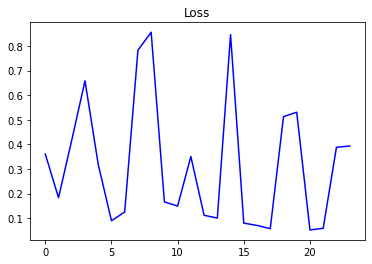

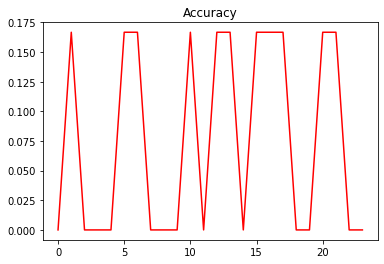

Epoch 1 Loss 0.393 Accuracy 0.00
Training done in 0 min (12 epochs with batches of 1)
Number of epoch
1


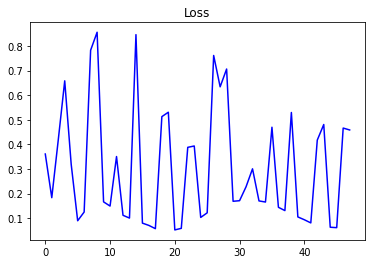

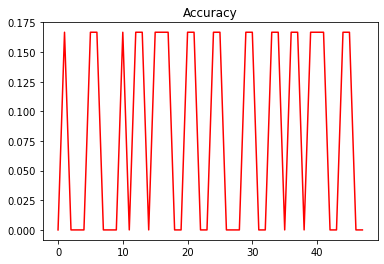

Epoch 2 Loss 0.459 Accuracy 0.00
Training done in 0 min (12 epochs with batches of 1)
Number of epoch
2


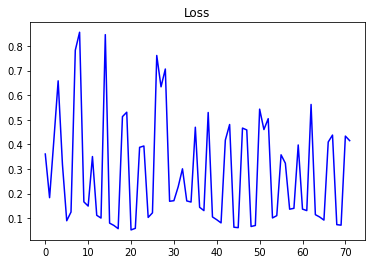

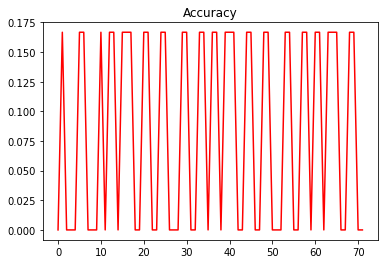

Epoch 3 Loss 0.415 Accuracy 0.00
Training done in 1 min (12 epochs with batches of 1)
Number of epoch
3


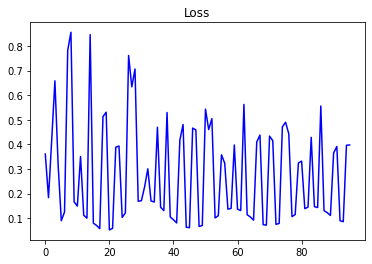

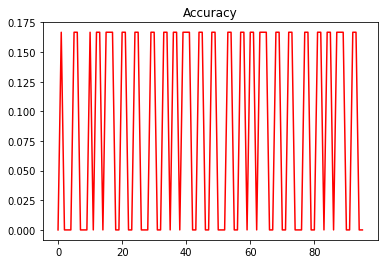

Epoch 4 Loss 0.398 Accuracy 0.00
Training done in 1 min (12 epochs with batches of 1)
Number of epoch
4


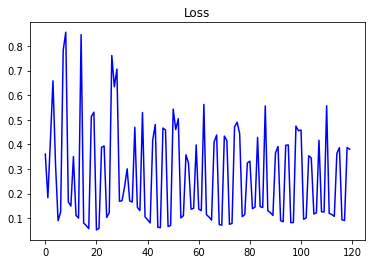

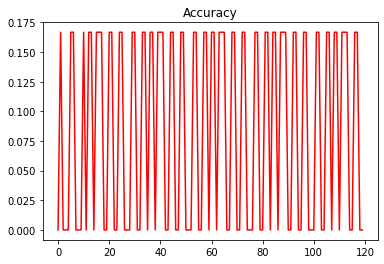

Epoch 5 Loss 0.381 Accuracy 0.00
Training done in 1 min (12 epochs with batches of 1)
Number of epoch
5


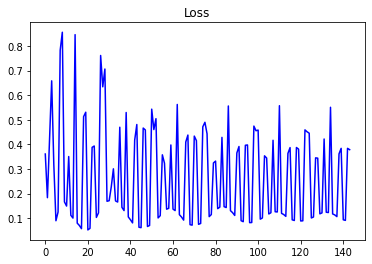

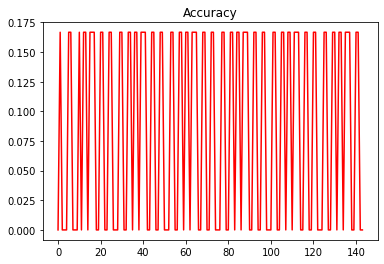

Epoch 6 Loss 0.379 Accuracy 0.00
Training done in 2 min (12 epochs with batches of 1)
Number of epoch
6


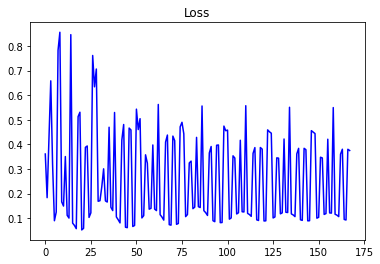

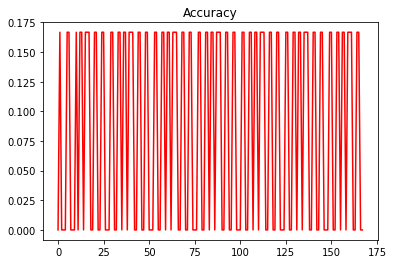

Epoch 7 Loss 0.375 Accuracy 0.00
Training done in 2 min (12 epochs with batches of 1)
Number of epoch
7


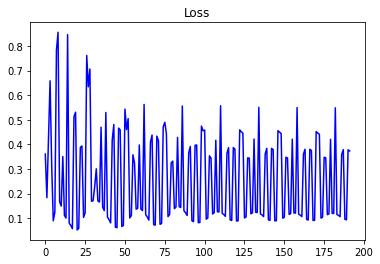

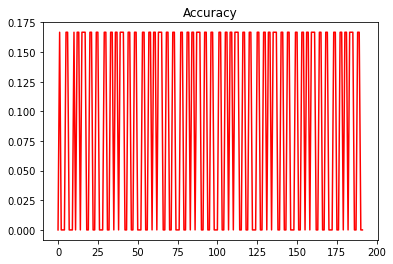

Epoch 8 Loss 0.373 Accuracy 0.00
Training done in 3 min (12 epochs with batches of 1)
Number of epoch
8


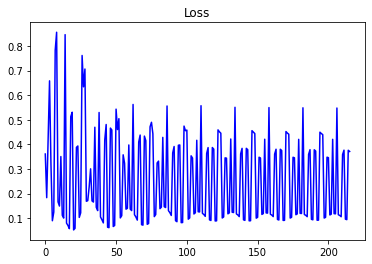

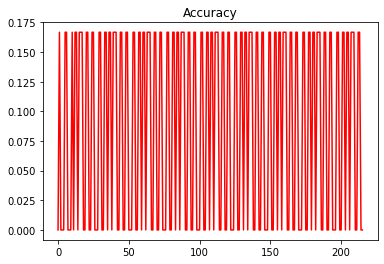

Epoch 9 Loss 0.371 Accuracy 0.00
Training done in 3 min (12 epochs with batches of 1)
Number of epoch
9


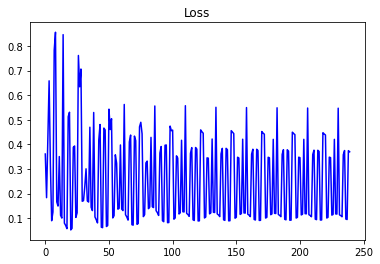

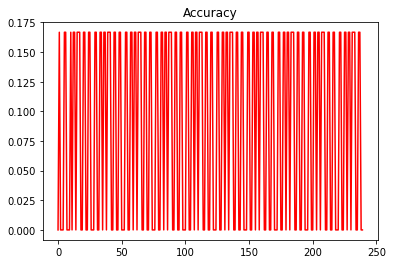

Epoch 10 Loss 0.370 Accuracy 0.00
Training done in 3 min (12 epochs with batches of 1)
Number of epoch
10


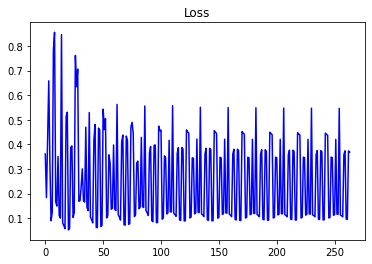

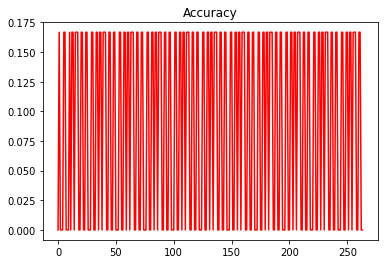

Epoch 11 Loss 0.369 Accuracy 0.00
Training done in 4 min (12 epochs with batches of 1)
Number of epoch
11


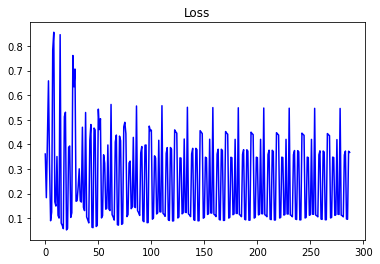

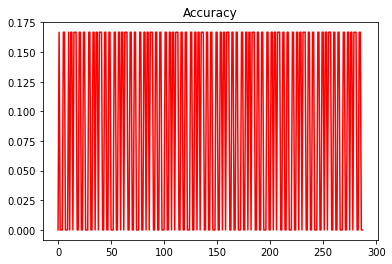

Epoch 12 Loss 0.368 Accuracy 0.00
Training done in 4 min (12 epochs with batches of 1)


In [214]:
batch_size = 1
n_epochs = 12

D_g = 150
D_p = 150
D_e = 100
D_c = 100

n_classes=8
glv_embedding_matrix = np.load(open('glv_embedding_matrix', 'rb') ,allow_pickle=True)
vocab_size, embedding_dim = glv_embedding_matrix.shape
cnn_output_size=100
max_num_tokens = 250
filters = 50
kernel_sizes = [3,4,5]
dropout = 0.5 


for r in range(dialogue_train_data.shape[0]):
    data = dialogue_train_data.iloc[43]
    
    number_of_speakers = len(set(data['speaker']))
    
    
    model = DialogueRNN(D_g, D_p, D_e, D_c, n_classes, number_of_speakers, vocab_size, embedding_dim, cnn_output_size , 
            max_num_tokens, glv_embedding_matrix, filters, kernel_sizes, dropout)
    
    loss = []
    acc = []
    start = time.time()
    for epoch in range(n_epochs):
        print("Number of epoch")
        print(epoch)
        for x, speaker, y  in zip(data["sequence"], data["encoded_speaker"], data["emotion_true"]):
                       #get the speaker id
                speakers_id = np.argmax(speaker)

                batch_loss, batch_acc = train_step(model, x, y, speakers_id)
                loss.append(batch_loss)
                acc.append(batch_acc)
                
        plt.plot(loss, color="blue")
        plt.title("Loss")
        plt.show()
        plt.plot(acc, color="red")
        plt.title("Accuracy")
        plt.show()
        print('Epoch %d Loss %.3f Accuracy %.2f' % (epoch + 1, batch_loss.numpy(), batch_acc.numpy()))
        training_time = (time.time() - start) / 60
        print("Training done in %d min (%d epochs with batches of %d)" % (training_time, n_epochs, batch_size))
    break
#encoder.save_weights("encoder.weights")
#decoder.save_weights("decoder.weights")